In [162]:
#Importing libraries needed for the project
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV

In [110]:
data=pd.read_csv("/home/kasia/data_ML/ML_data.csv")

In [111]:
data=data.set_index("id")

data["diagnosis_binary"]=data["diagnosis"]
data["diagnosis_binary"]=data["diagnosis_binary"].replace("B",0)
data["diagnosis_binary"]=data["diagnosis_binary"].replace("M",1)
data_ML=data.drop("diagnosis", axis=1)

/tmp/ipykernel_5452/2161451360.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["diagnosis_binary"]=data["diagnosis_binary"].replace("M",1)


In [112]:
data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_binary
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1


In [115]:
X=data_ML.iloc[:,1:30]
Y=data_ML["diagnosis_binary"]

In [117]:
Y.value_counts()
#there is a class imbalance in the data - more classified as 0 than 1
#to correct for class imbalance SMOTE is used
smote=SMOTE(random_state=42, sampling_strategy="minority")
X_res, Y_res=smote.fit_resample(X,Y)

In [118]:
#Splitting the data into the training and testing datasets, by default test is 25% of the data
X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res)

/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


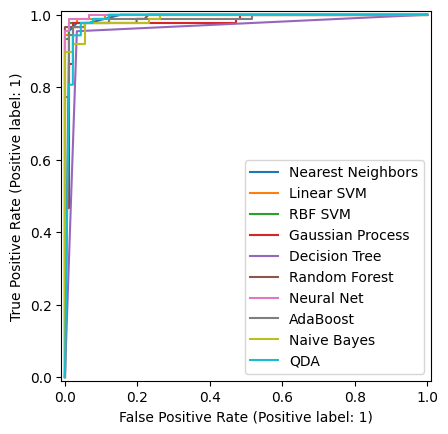

In [153]:
#Comparing ML classifiers for their potential to predict the class based on the features
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear", random_state=42),
    SVC(kernel="rbf", random_state=42),
    GaussianProcessClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier( random_state=42),
    MLPClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
ax=plt.gca()
scores={"Accuracy":[], "Precision":[],"Recall":[],"F1":[]}
ROC={}
for classifier in classifiers:
    pipe=make_pipeline(StandardScaler(), classifier)
    pipe.fit(X_train, Y_train)
    prediction=pipe.predict(X_test)
    scores["Accuracy"].append(accuracy_score(prediction, Y_test))
    scores["F1"].append(f1_score(prediction, Y_test))
    scores["Recall"].append(recall_score(prediction, Y_test))
    scores["Precision"].append(precision_score(prediction, Y_test))
    RocCurveDisplay.from_estimator(pipe, X_test, Y_test, ax=ax)
ax.legend(names)


In [154]:
comparison=pd.DataFrame(scores)
comparison["Models"]=names
comparison=comparison.set_index("Models")

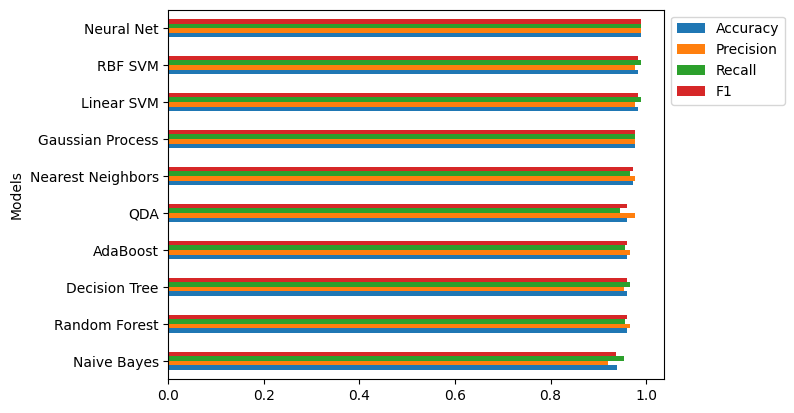

In [135]:
sorted=comparison.sort_values(by="Accuracy", ascending=True)
ax=sorted.plot.barh()
ax.legend(bbox_to_anchor=(1,1))

In [137]:
sorted

,Accuracy,Precision,Recall,F1
Models,,,,
Naive Bayes,0.938547,0.920455,0.952941,0.936416
Random Forest,0.960894,0.965909,0.955056,0.960452
Decision Tree,0.960894,0.954545,0.965517,0.960000
AdaBoost,0.960894,0.965909,0.955056,0.960452
QDA,0.960894,0.977273,0.945055,0.960894
Nearest Neighbors,0.972067,0.977273,0.966292,0.971751
Gaussian Process,0.977654,0.977273,0.977273,0.977273
Linear SVM,0.983240,0.977273,0.988506,0.982857
RBF SVM,0.983240,0.977273,0.988506,0.982857


In [167]:
#Hyperparameter tuning for the top 3 models
#Neural Net
pipe=make_pipeline(StandardScaler(), MLPClassifier(random_state=42))
params={"mlpclassifier__activation":["identity", "logistic", "tanh", "relu"],
        "mlpclassifier__alpha":[0.0001,0.001,0.01,0.1],
        "mlpclassifier__early_stopping":[True, False],
        "mlpclassifier__learning_rate":["constant","invscaling","adaptive"],
        "mlpclassifier__solver":["adam","lfbgs","sgd"]
        }

clf=GridSearchCV(pipe,param_grid=params,scoring="accuracy")
clf.fit(X_train, Y_train)
clf.best_params_

#This analysis indicated that the default parameters are best

/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/skle

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0])

{'mlpclassifier__activation': 'relu',
 'mlpclassifier__alpha': 0.0001,
 'mlpclassifier__early_stopping': False,
 'mlpclassifier__learning_rate': 'constant',
 'mlpclassifier__solver': 'adam'}